In [1]:
from os.path import join
import torch
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xgboost as xgb

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append("/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/scTab-devel/notebooks/model_evaluation")
from utils import correct_labels

In [3]:
torch.manual_seed(42)  # for reproducibility

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cpu'

In [6]:
CKPT_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL/model_XGBoost/run1/xgb_embedding_model.json'

: 

In [ ]:
clf = xgb.XGBClassifier()
clf.load_model(CKPT_PATH)
clf.set_params(predictor='gpu_predictor')
clf

In [8]:
import os

DATA_PATH = '/projects/b1042/GoyalLab/jaekj/SCTAB_FINAL'
test_emb = torch.load(os.path.join(DATA_PATH, "test_embedding.pt"), weights_only=True)

x_test = test_emb["X"]
y_test = test_emb["y"]
y_test_numpy = y_test.cpu().numpy()
unique_test_labels = torch.unique(y_test)

In [9]:
z0_obs_all = []
y_obs_all = []

for class_idx, label in enumerate(unique_test_labels):
    class_idxs = np.where(y_test_numpy == label.item())[0]
    n_class = len(class_idxs)

    if n_class > sample_size:
        idx = torch.randperm(n_class)[:sample_size]
        selected_idxs = torch.tensor(class_idxs)[idx]
    else:
        selected_idxs = torch.tensor(class_idxs)

    z0_obs_class = x_test[selected_idxs].to(device)
    y_class = y_test[selected_idxs].to(device)

    z0_obs_all.append(z0_obs_class)
    y_obs_all.append(y_class)

# Concatenate across all classes
z0_obs_all = torch.cat(z0_obs_all, dim=0)   # shape: (sum(selected per class), latent_dim)
y_obs_all = torch.cat(y_obs_all, dim=0)     # shape: (sum(selected per class),)

print(f"[INFO] Total selected samples: {z0_obs_all.shape[0]} across {len(unique_test_labels)} classes.")

[INFO] Total selected samples: 32746 across 164 classes.


In [10]:
z0_obs_all

tensor([[0.0000, 0.1783, 0.2822,  ..., 0.1338, 0.0694, 0.0000],
        [0.0746, 2.2188, 0.2635,  ..., 0.2381, 0.0090, 0.0730],
        [0.4596, 1.0789, 0.6281,  ..., 0.6297, 0.4031, 0.0865],
        ...,
        [0.1065, 0.0000, 0.9236,  ..., 0.0000, 0.6713, 0.3910],
        [0.0000, 0.0000, 1.1500,  ..., 0.0000, 1.6317, 1.0462],
        [0.3934, 0.0000, 1.1426,  ..., 0.0000, 0.8601, 0.0836]],
       device='cuda:0')

In [11]:
z0_obs_all_np = z0_obs_all.cpu().numpy()

In [12]:
print(z0_obs_all_np.shape)  # should be (164, feature_dim)

(32746, 128)


In [14]:
y_pred = clf.predict(z0_obs_all_np)

In [18]:
y_true = y_obs_all.cpu().numpy()

In [19]:
y_true = np.asarray(y_true, dtype=np.int64).ravel()
y_pred = np.asarray(y_pred, dtype=np.int64).ravel()

In [20]:
y_true.shape[0] == y_pred.shape[0]

True

In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Predict on test set
# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
report = classification_report(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.8207
Test F1-score: 0.8192
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.74       200
           1       1.00      0.85      0.92       200
           2       1.00      0.96      0.98       200
           3       0.85      0.96      0.90       200
           4       0.75      0.95      0.84       200
           5       0.96      0.49      0.65       200
           6       0.98      0.81      0.89       200
           7       0.83      0.94      0.88       200
           8       0.91      0.94      0.92       200
           9       0.35      0.40      0.38       200
          10       0.44      0.84      0.58       200
          11       0.84      0.69      0.76       200
          12       0.65      0.81      0.72       200
          13       0.97      0.77      0.86       200
          14       0.45      0.84      0.59       200
          15       0.54      0.81      0.65       200
          16  

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

clf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.820711,0.820711,0.820711,0.820711
macro avg,0.855492,0.820127,0.818910,32746.000000
weighted avg,0.855345,0.820711,0.819231,32746.000000


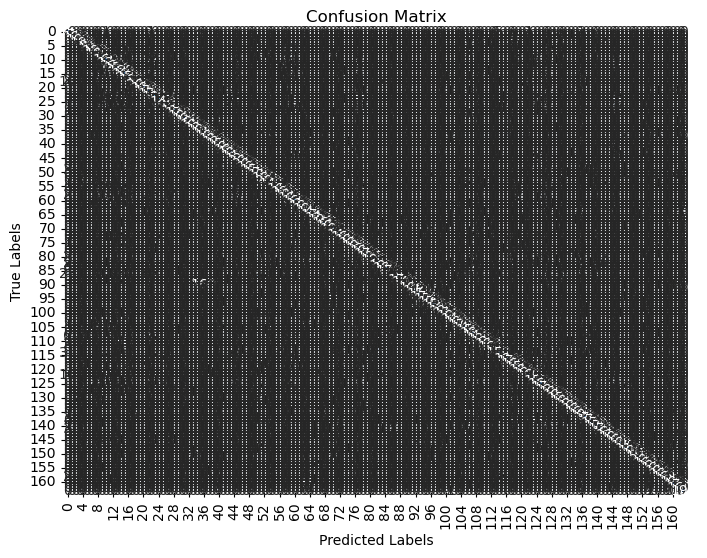

In [26]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [28]:
DATA_PATH = '/projects/b1042/GoyalLab/jaekj/merlin_cxg_2023_05_15_sf-log1p'
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

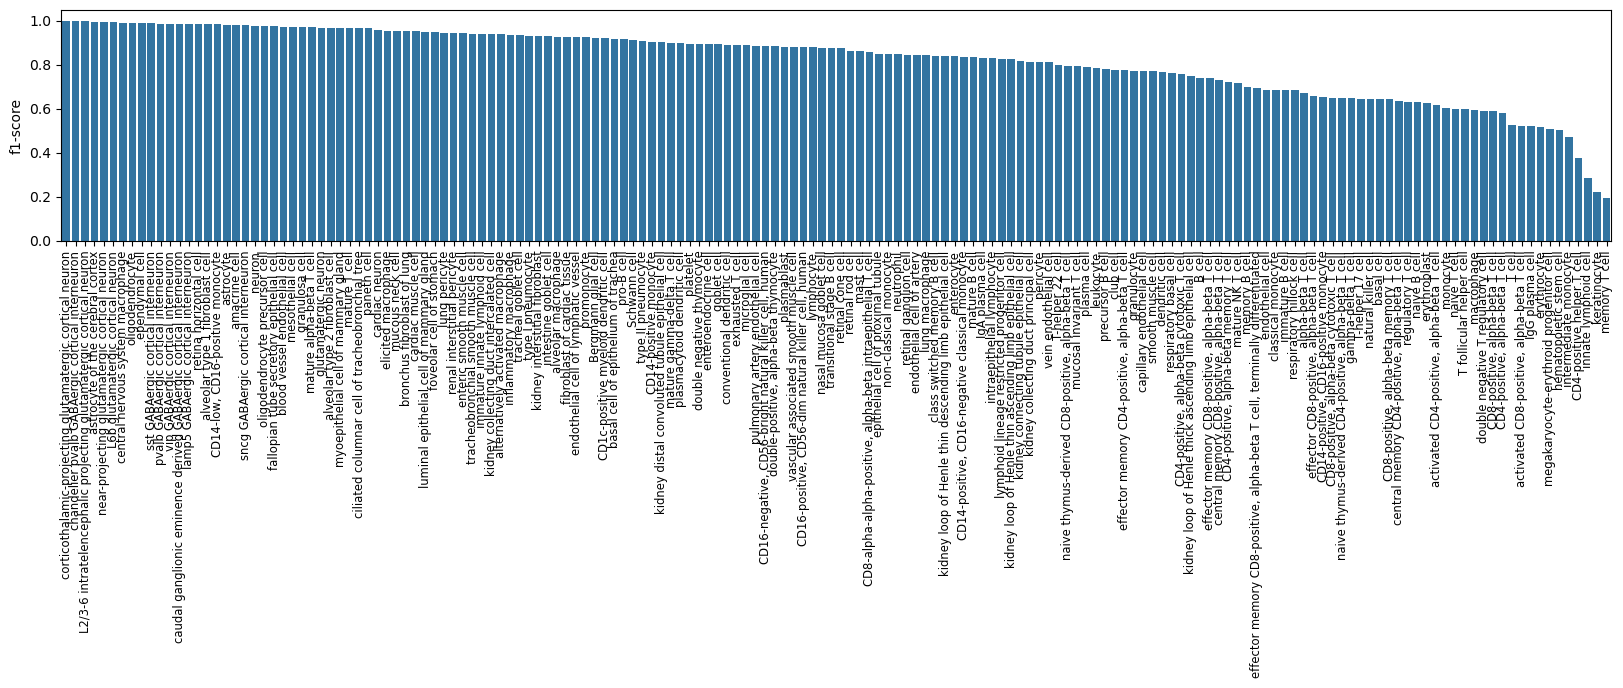

In [29]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small');